# Import Packages

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import networkx as nx
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Env

#

In [2]:
class FourRoomEnv(gym.Env):
    """
    Custom FourRoom environment with fixed start in upper-left room and goal in bottom-right room.
    Each room is 5x5, total grid 11x11 with walls separating rooms and hallways (gaps) connecting them.
    Reward: +1 only when reaching the goal, 0 otherwise.
    """
    def __init__(self):
        self.grid_size = 11
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Discrete(self.grid_size ** 2)
        self.start_pos = (0, 0)  # Upper-left room
        self.goal_pos = (10, 10)  # Bottom-right room
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right

        # Define walls (impassable positions)
        self.walls = set()
        # Add all positions in row 5 as potential walls
        for c in range(self.grid_size):
            self.walls.add((5, c))
        # Add all positions in column 5 as potential walls
        for r in range(self.grid_size):
            self.walls.add((r, 5))

        # Remove the gap positions from the walls
        self.walls.remove((2, 5)) # Vertical gap top
        self.walls.remove((8, 5)) # Vertical gap bottom
        self.walls.remove((5, 2)) # Horizontal gap left
        self.walls.remove((5, 8)) # Horizontal gap right

        # Build graph for optimal policy (using networkx)
        self.positions = [(r, c) for r in range(self.grid_size) for c in range(self.grid_size) if (r, c) not in self.walls]
        self.G = nx.Graph()
        for pos in self.positions:
            self.G.add_node(pos)
        for pos in self.positions:
            r, c = pos
            for dr, dc in self.actions:
                nr, nc = r + dr, c + dc
                if (nr, nc) in self.positions:
                    self.G.add_edge(pos, (nr, nc))

        # Compute shortest path distances to goal
        self.dist_to_goal = nx.shortest_path_length(self.G, target=self.goal_pos)

        # Precompute optimal actions for each position
        self.optimal_actions = defaultdict(list)
        for pos in self.positions:
            if pos == self.goal_pos:
                continue
            # Ensure pos is in dist_to_goal before accessing (should be true if graph is connected)
            if pos in self.dist_to_goal:
                dist = self.dist_to_goal[pos]
                for a_idx, (dr, dc) in enumerate(self.actions):
                    nr, nc = pos[0] + dr, pos[1] + dc
                    if (nr, nc) in self.positions and self.dist_to_goal.get((nr, nc), float('inf')) == dist - 1:
                        self.optimal_actions[pos].append(a_idx)

        self.reset()

    def reset(self, *, seed=None, options=None):
        self.current_pos = self.start_pos
        return self.pos_to_state(self.current_pos), {}

    def pos_to_state(self, pos):
        return pos[0] * self.grid_size + pos[1]

    def state_to_pos(self, state):
        return divmod(state, self.grid_size)

    def step(self, action):
        row, col = self.current_pos
        dr, dc = self.actions[action]
        new_row, new_col = row + dr, col + dc
        if 0 <= new_row < self.grid_size and 0 <= new_col < self.grid_size and (new_row, new_col) not in self.walls:
            self.current_pos = (new_row, new_col)
        terminated = self.current_pos == self.goal_pos
        reward = 1 if terminated else 0
        truncated = False  # No time limit
        return self.pos_to_state(self.current_pos), reward, terminated, truncated, {}

    def get_action(self, pos, epsilon=0.3):
        """
        Epsilon-greedy policy based on optimal actions.
        With prob epsilon, random action; else, random optimal action.
        """
        if random.random() < epsilon or not self.optimal_actions[pos]:
            return random.randint(0, 3)
        return random.choice(self.optimal_actions[pos])

In [3]:
# Plot Env
# Function to plot the environment
def plot_four_room(env):
    grid = np.zeros((env.grid_size, env.grid_size))
    for r in range(env.grid_size):
        for c in range(env.grid_size):
            if (r, c) in env.walls:
                grid[r, c] = 1  # Walls (black)
            elif (r, c) == env.start_pos:
                grid[r, c] = 2  # Start (green)
            elif (r, c) == env.goal_pos:
                grid[r, c] = 3  # Goal (red)
            else:
                grid[r, c] = 0  # Empty (white)

    # Define custom colormap: white, black, green, red
    colors = ['white', 'black', 'green', 'red']
    cmap = ListedColormap(colors)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap=cmap, origin='upper')
    #plt.title('FourRoom Environment')
    #plt.xlabel('Column')
    #plt.ylabel('Row')
    #plt.colorbar(ticks=[0, 1, 2, 3], label='0: Empty (white), 1: Wall (black), 2: Start (green), 3: Goal (red)')
    #plt.grid(True, which='both', color='gray', linewidth=0.5)
    plt.show()

# Data Generate

In [10]:
# Code to generate medium-quality offline dataset
def generate_dataset(env, num_episodes=100, max_steps=100, epsilon=0.88):
    dataset = []  # List of (s, a, r, s', done)
    for ep in range(num_episodes):
        s, _ = env.reset()
        traj = []
        for step in range(max_steps):
            pos = env.state_to_pos(s)
            a = env.get_action(pos, epsilon)
            s_next, r, done, _, _ = env.step(a)
            traj.append((s, a, r, s_next, done))
            s = s_next
            if done:
                break
        dataset.append(traj)
    return dataset

# RUN

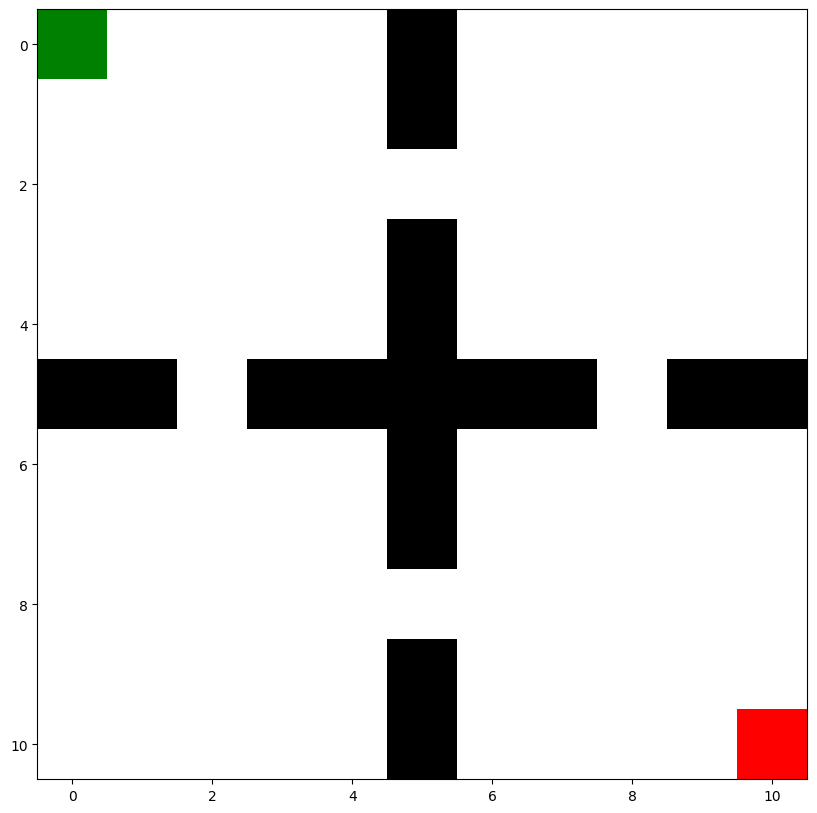

In [11]:
# Example usage
env = FourRoomEnv()
plot_four_room(env)

#dataset = generate_dataset(env, num_episodes=50)  # Generate 50 episodes for medium-sized dataset

# To save or use the dataset, e.g., print length
#print(f"Generated dataset with {len(dataset)} transitions.")

In [12]:
dataset = generate_dataset(env, num_episodes=1000)  # Generate 50 episodes for medium-sized dataset

# Check Generate Datasets

In [13]:
dataset[0][0]

(0, 1, 0, 11, False)

In [14]:
length = 0
success_rate = 0
for i in range(len(dataset)):
    length += len(dataset[i])
    for j in range(len(dataset[i])):
        if dataset[i][j][4] == True:
            success_rate += 1
success_rate /= len(dataset)

avg_length = length / len(dataset)

print(f"Average episode length: {avg_length:.2f} steps")
print(f"Success rate: {success_rate:.2%}")

Average episode length: 97.21 steps
Success rate: 13.70%


In [15]:
dataset[0]

[(0, 1, 0, 11, False),
 (11, 3, 0, 12, False),
 (12, 3, 0, 13, False),
 (13, 3, 0, 14, False),
 (14, 1, 0, 25, False),
 (25, 1, 0, 36, False),
 (36, 3, 0, 37, False),
 (37, 0, 0, 26, False),
 (26, 3, 0, 27, False),
 (27, 1, 0, 27, False),
 (27, 2, 0, 26, False),
 (26, 0, 0, 15, False),
 (15, 0, 0, 4, False),
 (4, 0, 0, 4, False),
 (4, 0, 0, 4, False),
 (4, 1, 0, 15, False),
 (15, 2, 0, 14, False),
 (14, 0, 0, 3, False),
 (3, 2, 0, 2, False),
 (2, 1, 0, 13, False),
 (13, 0, 0, 2, False),
 (2, 1, 0, 13, False),
 (13, 0, 0, 2, False),
 (2, 1, 0, 13, False),
 (13, 1, 0, 24, False),
 (24, 3, 0, 25, False),
 (25, 2, 0, 24, False),
 (24, 3, 0, 25, False),
 (25, 2, 0, 24, False),
 (24, 3, 0, 25, False),
 (25, 3, 0, 26, False),
 (26, 2, 0, 25, False),
 (25, 3, 0, 26, False),
 (26, 2, 0, 25, False),
 (25, 3, 0, 26, False),
 (26, 3, 0, 27, False),
 (27, 1, 0, 27, False),
 (27, 2, 0, 26, False),
 (26, 2, 0, 25, False),
 (25, 3, 0, 26, False),
 (26, 3, 0, 27, False),
 (27, 1, 0, 27, False),
 (27, 2

# Save

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pickle

In [18]:
filename = f"drive/MyDrive/Colab Notebooks/LLMAgent/FourRoom/Datasets/FourRoom-Low.pkl"

In [19]:
with open(filename, "wb") as f:
  pickle.dump(dataset, f)
  print(f"Saved {len(dataset)} trajectories to {filename}")

Saved 1000 trajectories to drive/MyDrive/Colab Notebooks/LLMAgent/FourRoom/Datasets/FourRoom-Low.pkl
